## Latitude, Longitude, and Year

In order to attempt to find relationships between artist location and year, with the hope of identifying clusters pointing to musical hotspots at times they were most active, as well as the way these locations may change over time.

Beginning with the basic setup and imports:

In [1]:
import pandas as pd
import numpy as np
import pickle

import sys, os
tim_path = 'C:\\Users\\Tim\\PycharmProjects\\625.687\src'
ben_path = '/Users/ben/Documents/625.687/src'

if os.path.exists(tim_path):
    sys.path.append(tim_path) # your local repo here
elif os.path.exists(ben_path):
    sys.path.append(ben_path)
else:
    print("Problem accessing src directory.")

try:
    path = "C:\\Users\\Tim\\Desktop\\MillionSongSubsetMillionSongSubset_dataframe.pkl" # your local data here
    df = pickle.load(open(path, "rb"))
except:
    path = ben_path + "/MillionSongSubset_dataframe.track_id_year_artist_longitude_artist_latitude.pkl"
    df = pickle.load(open(path, "rb"))
#for c in sorted(df.columns):
#    print(c)

Now, some data cleaning:

In [2]:
import msd_utils

# Set up dataframe 
#df = df[["year", "artist_latitude", "artist_longitude"]]
df = df.dropna()
df = df[df["year"] != 0]
subdf = df[["year", "artist_latitude", "artist_longitude"]]

print(len(subdf))

1825


Finally, building the distance matrix using our metric `year_lat_lon`, stored in `Metrics.py`.

In [3]:
import Metrics

mf = Metrics.Metric() # metric factory
metrics_df = []

# Compute a square matrix of scores (every song against every song)
for index1, row1 in subdf.iterrows():
    metric_scores = []
    for index2, row2 in subdf.iterrows():
        try:
            score = mf.year_lat_lon(row1, row2)
            metric_scores.append(score)
        except:
            print(row1)
            print(row2)
    metrics_df.append(metric_scores)

dmatrix = np.array(metrics_df)

Now that we have our distance metric, we can compute the persistence diagram for $H_0$ and $H_1$. The computation for $H_2$ is, unfortunately, prohibitively expensive for the entire dataset.

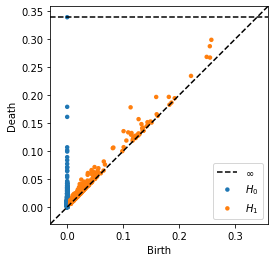

In [4]:
from ripser import ripser
from persim import plot_diagrams, persistent_entropy

res = ripser(dmatrix, distance_matrix=True)
plot_diagrams(res['dgms'], show=True)

In [5]:
persistent_entropy.persistent_entropy(res['dgms'])

array([6.64719382, 5.87886522])

In order to attempt to find some sort of structure in $H_2$, we'll try it with an abbreviated distance matrix.

In [6]:
dmatrix_sub = dmatrix[:300, :300]

res_sub = ripser(dmatrix_sub, distance_matrix=True, maxdim=2)

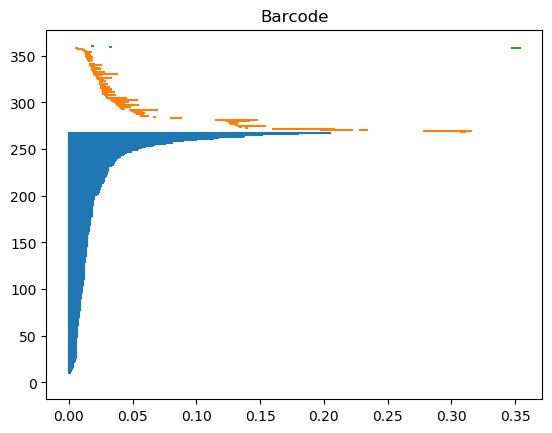

In [7]:
import matplotlib.pyplot as plt

def barcode(dgms, show=True):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    baseline = 0
    for d, homology in enumerate(dgms):
        for e, ele in enumerate(homology):
            plt.plot([ele[0], ele[1]], [baseline+e, baseline+e],
                    color=colors[d])
        baseline += e
    if show:
        plt.title("Barcode")
        plt.show()

barcode(res_sub['dgms'])

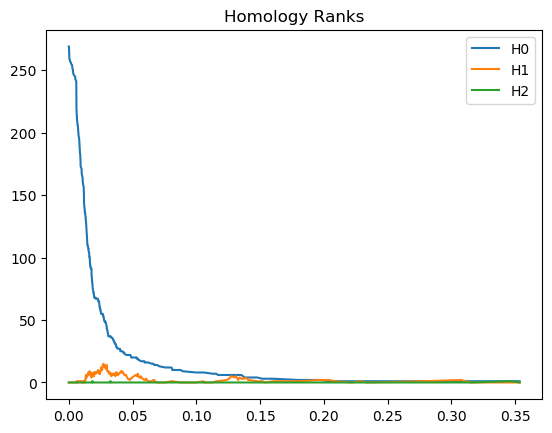

[269, 268, 267, 262, 266, 264, 261, 260, 259, 258, 257, 256, 255, 254, 252, 251, 89, 28, 20, 14, 73, 57, 95, 119, 33, 250, 181, 182, 162, 157, 153, 126, 122, 110, 63, 1, 111, 195, 166, 163, 144, 141, 138, 115, 109, 108, 120, 120, 217, 211, 174, 180, 249, 30, 173, 183, 164, 143, 142, 139, 137, 123, 79, 107, 202, 192, 27, 18, 97, 216, 203, 198, 194, 193, 191, 188, 76, 44, 16, 215, 214, 197, 37, 31, 30, 12, 23, 89, -1, 179, 116, 241, 199, 190, 184, 172, 167, 145, 140, 178, 154, 121, 14, 66, 165, 145, 35, 17, 171, 84, 53, 109, 152, 239, 18, 10, 9, 16, 5, 46, 12, 9, 2, 56, 169, 130, 62, 37, 38, 84, 78, 28, 220, 210, 206, 196, 112, 247, 98, 56, 35, 0, 59, 41, 34, 13, 85, 88, 2, 71, 136, 131, 244, 243, 103, 125, 113, 177, 186, 213, 21, 1, 69, 63, 8, 94, 89, 73, 246, 242, 200, 25, 25, 65, 54, 49, 96, 67, 55, 170, 240, 133, 48, 91, 80, 32, 74, 52, 90, 55, 29, 101, 70, 63, 39, 27, 36, 7, 22, 17, 14, 12, 13, 106, 218, 215, 204, 201, 161, 156, 75, 76, 29, 155, 114, 124, 105, 176, 209, 207, 189, 18

In [8]:
def homology_ranks(dgms, show=True):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    baseline = 0
    agg = {0:{}}
    # For each homology in the array from Ripser
    for dim, homology in enumerate(dgms):
        # Collect all of the distances for births...
        dists = {span[0] for span in homology}
        # ...and deaths...
        dists = dists.union({span[1] for span in homology if span[1] != 'inf'})
        # Sort the distances and add to the aggregate dictionary.
        for d in dists:
            agg[d] = {}
    
    for dim, homology in enumerate(dgms):
        # Count the number of elements alive at distance d
        count = []
        for dist in sorted(agg):
            cnt = len([h for h in homology if h[0] <= dist and dist < h[1]])
            agg[dist][dim] = cnt
        # Add the counts to the plot.
        plt.plot(sorted([d for d in agg]), [agg[d][dim] for d in sorted(agg)],
                color=colors[dim], label=f"H{dim}")
    if show:
        plt.legend()
        plt.title("Homology Ranks")
        plt.show()

    # Various other computations:
    for dist in agg:
        e_ch = sum([((-1)**dim)*agg[dist][dim] for dim, _ in enumerate(dgms)])
        agg[dist]['euler_char'] = e_ch

    return agg
    

agg = homology_ranks(res_sub['dgms'])
print([agg[d]['euler_char'] for d in agg])

There still appears to be not much structure here...

Using another submodule called KeplerMapper, we'll take another look at the data to see if any clusters arise:

In [10]:
import kmapper as km

subdf_array = np.array(df[['year', 'artist_latitude', 'artist_longitude']])

mapper = km.KeplerMapper(verbose=1)
projected_data = mapper.fit_transform(dmatrix, distance_matrix=True, projection=[0,1])
graph = mapper.map(projected_data, subdf_array)
mapper.visualize(graph, path_html="YearLatLon_km_output.html",
                 title="Year, Latitude, Longitude")

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: True
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (1825, 1825)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler(copy=True, feature_range=(0, 1))

Mapping on data shaped (1825, 3) using lens shaped (1825, 2)

Creating 100 hypercubes.

Created 30 edges and 165 nodes in 0:00:00.042871.
Wrote visualization to: YearLatLon_km_output.html


ity\nfunction toggle_pane(content, content_id, tag) {\n  var active = content.active ? false : true;\n\n  if (active) {\n    content_id.style("display", "block");\n    tag.node().textContent = "[-]";\n  } else {\n    content_id.style("display", "none");\n    tag.node().textContent = "[+]";\n  }\n\n  // TODO: This is probably not the best way to find the correct height.\n  var h = canvas_height - content.offsetTop - padding;\n  content_id.style("height", h + "px")\n\n  content.active = active;\n}\n\nd3.select("#tooltip_control").on("click", function(e) {\n  toggle_pane(tooltip_content,\n              d3.select("#tooltip_content"),\n              d3.select("#tooltip_tag"))\n\n});\n\nd3.select("#meta_control").on("click", function(e) {\n  toggle_pane(meta_content,\n              d3.select("#meta_content"),\n              d3.select("#meta_tag"))\n\n});\n\nd3.select("#help_control").on("click", function(e) {\n  toggle_pane(helptip_content,\n              d3.select("#helptip_content"),\n    